### Загрузка данных

In [1]:
import yfinance as yf

def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-22')
    return tickerDf.iloc[:, :5]

apple_df = get_price_data('AAPL')
nike_df = get_price_data('NKE')

Временной ряд стоимости акций компаний Apple и Nike

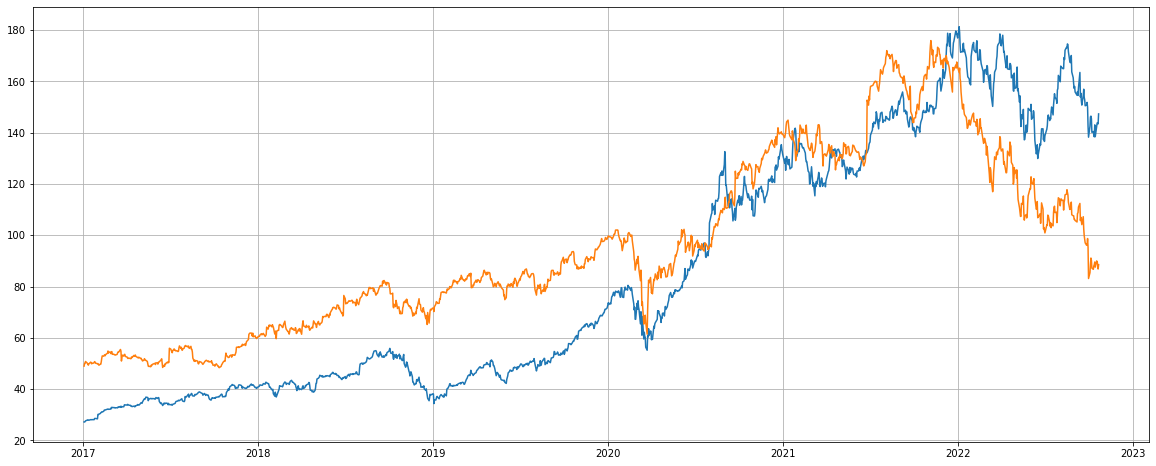

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(apple_df['Close'], linewidth=1.5)
plt.plot(nike_df['Close'], linewidth=1.5)
plt.grid(True)
plt.show()

### Стационарность временного ряда

Проведем тест Дикки - Фуллера для проверки гипотез о стационарности временных рядов. Наши ряды нужно привести к стационарным, для того чтобы будущие прогнозы были более вероятными и предсказуемыми.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import warnings 

warnings.filterwarnings('ignore')

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Временной ряд Apple

Results of Dickey-Fuller Test:
Test Statistic                   -0.636742
p-value                           0.862462
#Lags Used                       22.000000
Number of Observations Used    1439.000000
Critical Value (1%)              -3.434902
Critical Value (5%)              -2.863551
Critical Value (10%)             -2.567840
dtype: float64


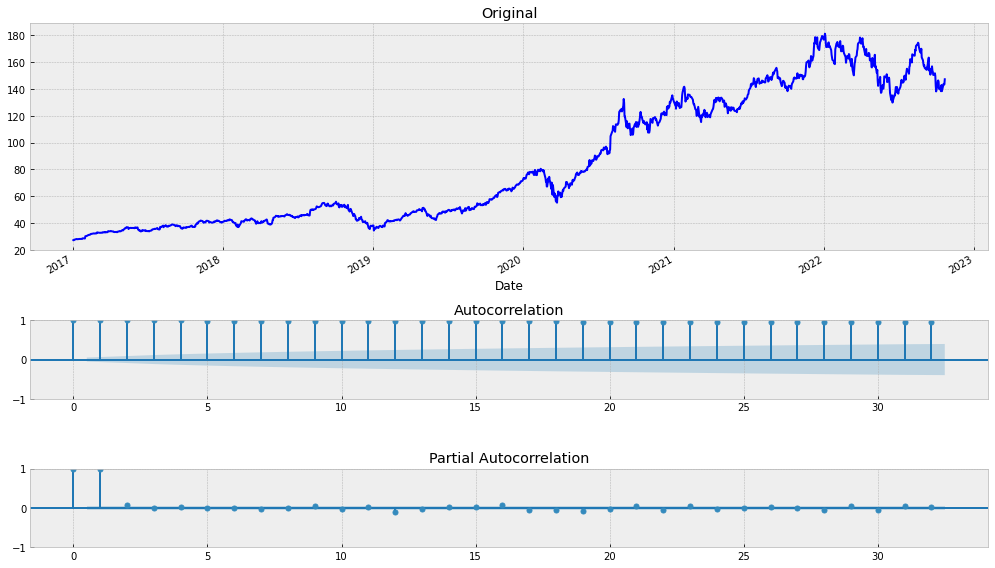

In [4]:
series = apple_df['Close']
tsplot(series)

Согласно тесту Дики-Фулера наш ряд не является стационарным. Графики автокорреляций говорят о наличии трендов и сезонных колебаний в ряду. Попробуем произвести преобразование Бокс-Кокса для стабилизации дисперсии временного ряда.

Results of Dickey-Fuller Test:
Test Statistic                   -1.081145
p-value                           0.722532
#Lags Used                        9.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


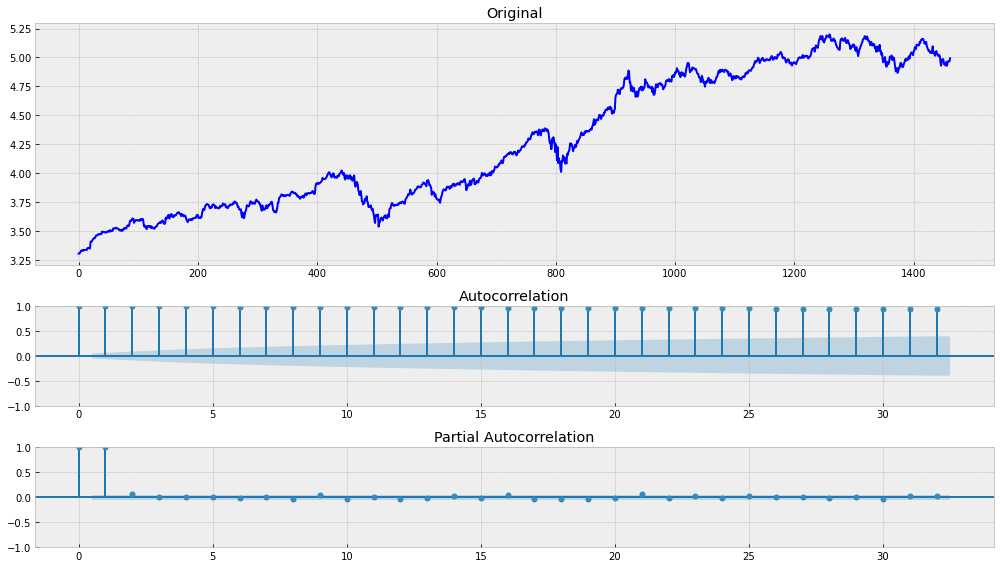

In [5]:
series = boxcox(series, 0)
tsplot(series)

На графике видно что уменьшен размах выборочных значений, но наблюдается наличие сильного тренда. Можно попробовать убрать его интегрированием.

Results of Dickey-Fuller Test:
Test Statistic                -1.199090e+01
p-value                        3.523175e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.452000e+03
Critical Value (1%)           -3.434862e+00
Critical Value (5%)           -2.863533e+00
Critical Value (10%)          -2.567831e+00
dtype: float64


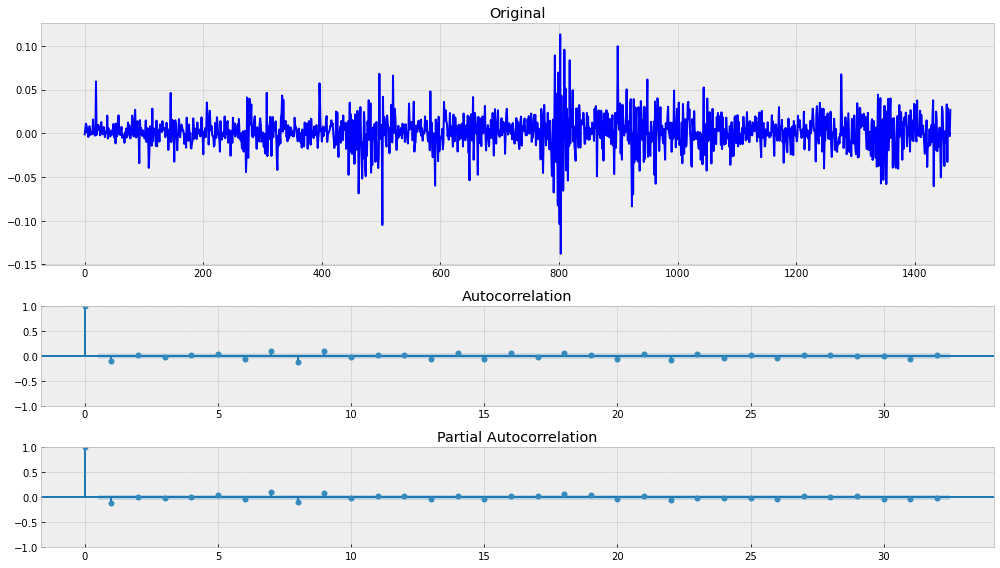

In [6]:
series = series[1:] - series[:-1]
tsplot(series)

Исходный ряд был приведен к стационарному путем применения преобразования Бокс-Кокса и интегрированием первого порядка. Произведем те же манипуляции с временным рядом Nike.

Results of Dickey-Fuller Test:
Test Statistic                -9.758036e+00
p-value                        7.695274e-17
#Lags Used                     1.500000e+01
Number of Observations Used    1.445000e+03
Critical Value (1%)           -3.434884e+00
Critical Value (5%)           -2.863542e+00
Critical Value (10%)          -2.567836e+00
dtype: float64


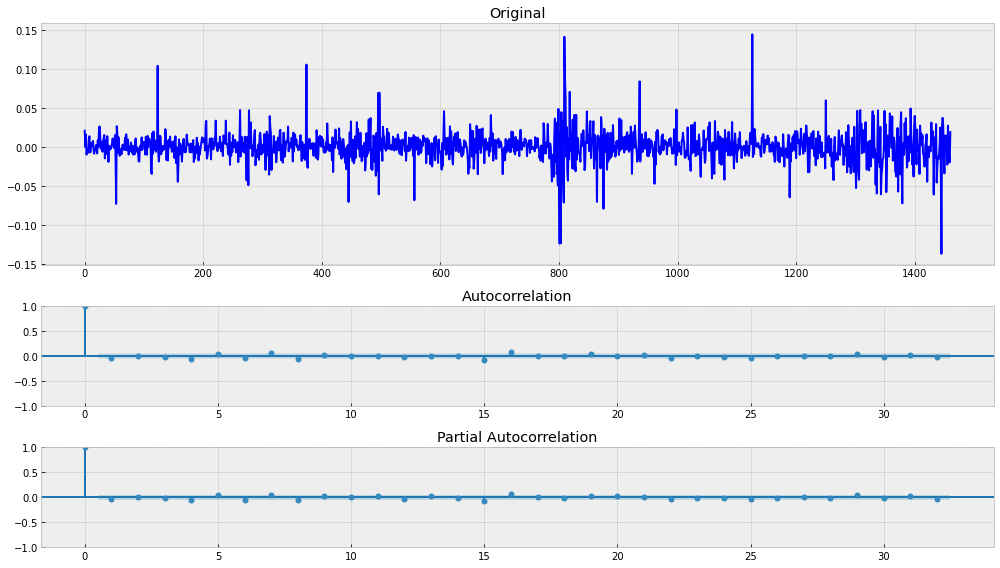

In [7]:
series = nike_df['Close']
series = boxcox(series, 0)
series = series[1:] - series[:-1]
tsplot(series)

### Нормальность временного ряда

In [8]:
import seaborn as sns
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan,
                                   het_goldfeldquandt,
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval < 0.05 else 'Not Normal'

def print_result(data,color):
    normal_args = (np.mean(data),np.std(data))

    print('Test1: ', is_normal(shapiro(data)))
    print('Test2: ', is_normal(normaltest(data)))
    print('Test3: ', is_normal(normal_ad(data)))
    print('Test4: ', is_normal(kstest_normal(data)))
    print('Test5: ', is_normal(kstest(data,
                   cdf='norm',
                   args=normal_args)))
    
    sns.histplot(data=data, kde=True, color=color).set(title='Гистограмма временного ряда');

Проверим значения временного ряда Applе на нормальность, путем произведения серии тестов

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


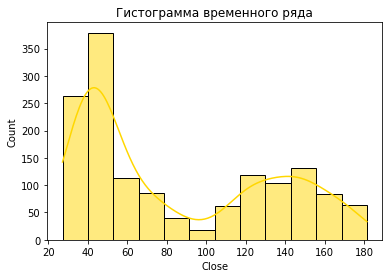

In [9]:
print_result(apple_df['Close'],'gold')

Временной ряд Nike

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


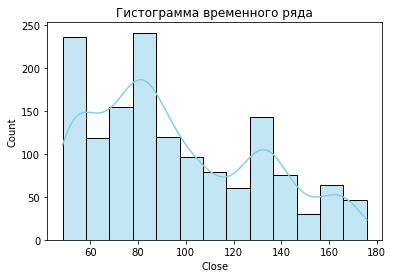

In [10]:
print_result(nike_df['Close'],'skyblue')

Как мы видим, по результатам тестов значения временных рядов подчинены нормальному распределению

Применяя к рядам преобразование Бокс-Кокса гистограммы рядов становятся более сглаженными по пикам

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


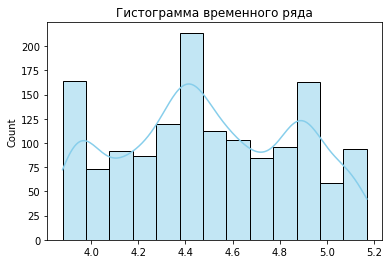

In [11]:
bc = boxcox(nike_df['Close'], 0)
print_result(bc,'skyblue')

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


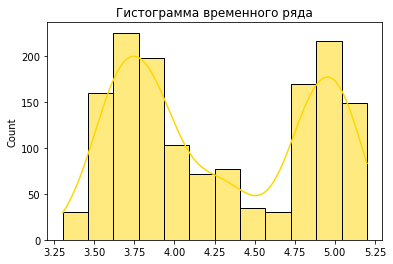

In [12]:
bc = boxcox(apple_df['Close'], 0)
print_result(bc,'gold')

### Декомпозиция временного ряда

In [13]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

ts = apple_df['Close']
ts = ts.asfreq('M')
ts = ts.ffill()

Установили периодичность в месяц, чтобы сгладить ряд и заметить характеристики на дистанции

In [14]:
ts_decomposed = seasonal_decompose(ts, model='multiplicative')

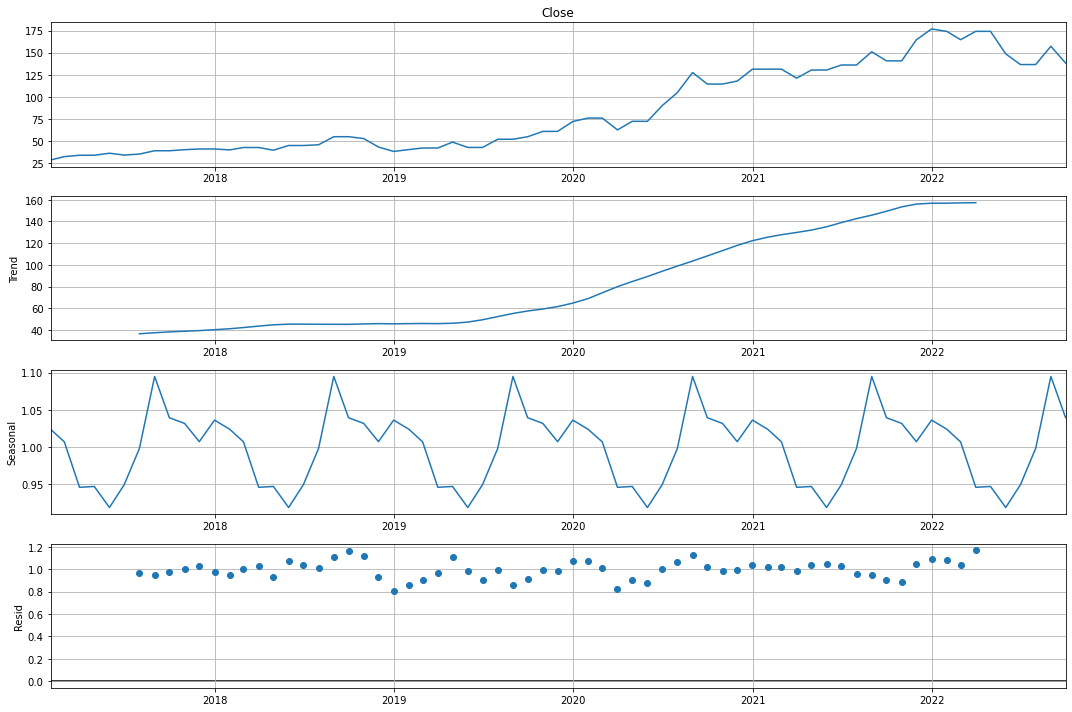

In [15]:
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams.update({"axes.grid" : True})

ts_decomposed.plot();

Временной ряд Apple на дистанции обладает восходящим трендом. Определена сезонность в 12 месяцев. Видно, что после первого квартала стоимость акций находится на дне, и к концу второго квартала достигают максимума.

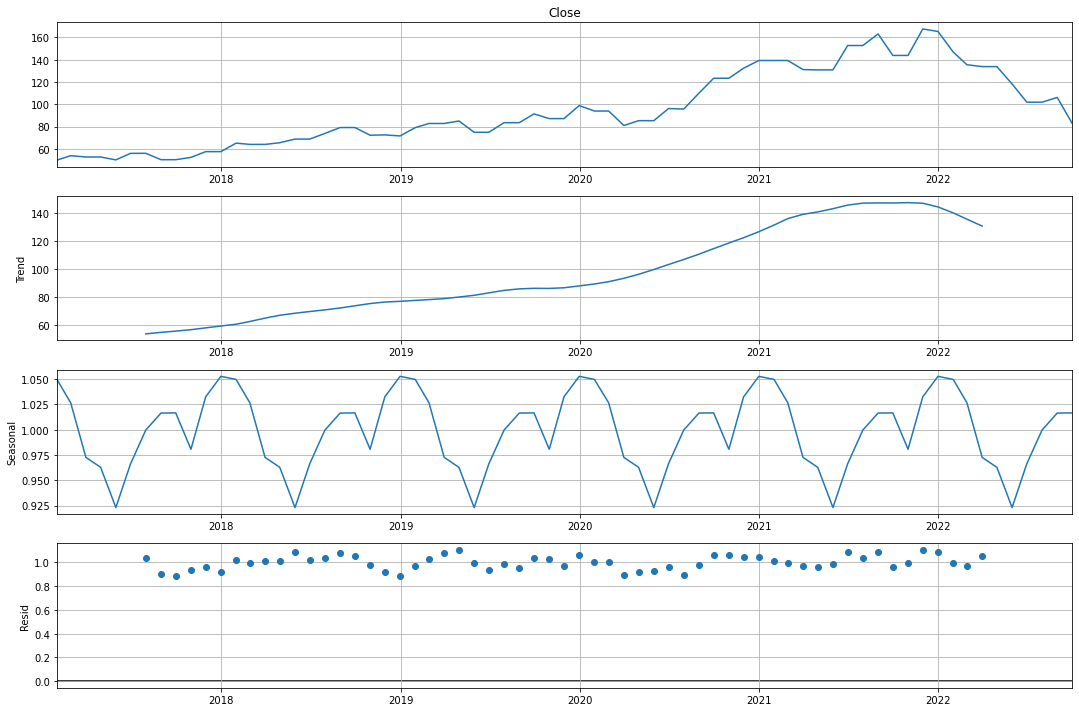

In [16]:
ts = nike_df['Close']
ts = ts.asfreq('M')
ts = ts.ffill()

ts_decomposed = seasonal_decompose(ts, model='multiplicative')
ts_decomposed.plot();

Временной ряд Nike обладает восходящим трендом до начала 2022 года, далее имеется медвежий тренд. Получена сезонность в 12 месяцев, видно, что к середине года акции падают в стоимости.

Как резюме, можно сказать следующее:

    1. Исходные ряды были не стационарными. Путем применения Бокс-Кокса и дифференцирования первого порядка получены стационарные ряды -- тестом Дикки-Фулера после преобразований была отвергнута гипотеза о нестационарности.
    2. По результатам проведенных на нормальность тестов - исходные временные ряды обладают нормально распределенными значениями.
    3. Проведя декомпозицию временных рядов вычислили возрастающий тренд и определили сезонность с периодом в 12 месяцев.